In [16]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import random
import time
import joblib
import os
from utils import render_single, render_multiple, get_dataset_files, extract_random_entries, extract_first_entries, generate_pixel_columns
from IPython.display import display, Image as IPImage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
num_cats = 2
entries_per_cat = 1000

files = get_dataset_files()
files = random.sample(files, num_cats)
# files = ['./dataset/shorts.ndjson', './dataset/motorbike.ndjson', './dataset/envelope.ndjson', './dataset/suitcase.ndjson', './dataset/parrot.ndjson', './dataset/t-shirt.ndjson', './dataset/lighthouse.ndjson', './dataset/flip flops.ndjson', './dataset/speedboat.ndjson', './dataset/toothpaste.ndjson', './dataset/door.ndjson', './dataset/clarinet.ndjson', './dataset/lollipop.ndjson', './dataset/raccoon.ndjson', './dataset/microphone.ndjson', './dataset/mountain.ndjson', './dataset/traffic light.ndjson', './dataset/butterfly.ndjson', './dataset/spoon.ndjson', './dataset/spider.ndjson', './dataset/campfire.ndjson', './dataset/popsicle.ndjson', './dataset/frog.ndjson', './dataset/hot dog.ndjson', './dataset/elephant.ndjson']
data = [extract_first_entries(file, entries_per_cat, recognized=True) for file in files]
flat_data = [item for sublist in data for item in sublist]
df_loaded = pd.DataFrame.from_dict(flat_data, orient='columns')
print(f'Loaded {len(df_loaded)} entries from {files}')

Loaded 2000 entries from ['./dataset/bicycle.ndjson', './dataset/bird.ndjson']


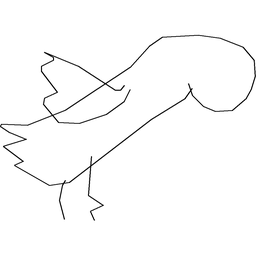

bird


In [18]:
img = random.choice(flat_data)
display(IPImage(render_single(img['drawing'])))
print(img['word'])

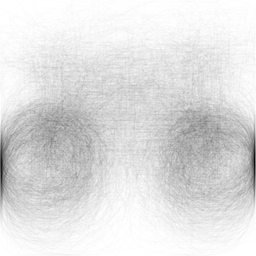

1000 superimposed bicycles.


In [19]:
count = 1000 if entries_per_cat > 1000 else entries_per_cat
word = random.choice(df_loaded['word'].values)
imgs = df_loaded[df_loaded['word'] == word].sample(count)
display(IPImage(render_multiple(imgs['drawing'])))
print(f'{count} superimposed {word}s.')

In [20]:
df = df_loaded.sample(len(df_loaded))
print('Done shuffling dataset')
df = generate_pixel_columns(df, resolution=64, invert_color=True, stroke_width_scale=2)
print('Done generating pixel columns')
df = df.reset_index()

train_amt = int(len(df) * .9)

train = df[:train_amt]
test = df[train_amt:]
# del df

train = train.reset_index()
test = test.reset_index()

print(f'Train: {len(train)} entries, test: {len(test)} entries.')

Done shuffling dataset
Done generating pixel columns
Train: 1800 entries, test: 200 entries.


In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_on = True

y = train['word']
X = train.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word'])
print("Done generating features and target")

if pca_on:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca = PCA(.85)
    X = pca.fit_transform(X)
    print(f'PCA & standardization done. Keeping {pca.n_components_} features')

save_to_disk = True

if save_to_disk:
    stamp = str(int(time.time()))
    folder = f'./runs/{stamp}/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    pd.DataFrame.to_feather(df, folder + 'data')
    print('Done saving dataset to disk')
    if pca_on:
        joblib.dump(pca, folder + 'pca')
        joblib.dump(pca, folder + 'scaler')
        print('Done saving PCA and scaler to disk')

In [34]:
print("type:", type(X), type(train), type(test))
print("columns:", len(X.columns))

type: <class 'numpy.ndarray'>


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

```
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

grid = GridSearchCV(
    estimator=SVC(),
    param_grid={
        'C': [2.4, 2.45, 2.5, 2.55, 2.6],
    },
    refit=True,
    verbose=2,
    n_jobs=-1
)

grid.fit(X,y)

print('Best hyperparameters:', grid.best_params_)
```

Best hyperparameters: {'C': 2.5, 'gamma': 0.009}

DataFrame creation done
PCA fit+transform done. Keeping [3.33506114e+07 7.21758618e+02]% variance
Scaler fit+transform done
OPTICS clustering done
DBSCAN (0.5) clustering done
DBSCAN (2) clustering done


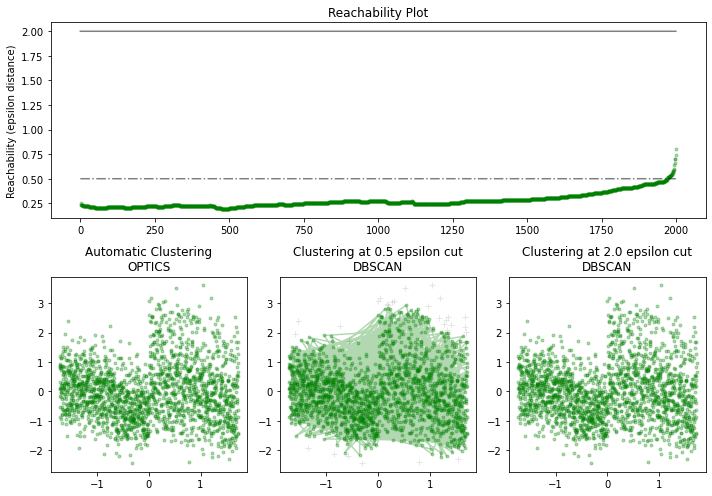

In [23]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)

# Run the fit
df2 = df.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word'])
print("DataFrame creation done")
comp_or_var = 2
da_pca = PCA(comp_or_var)
da_scaler = StandardScaler()
df2 = da_pca.fit_transform(df2)
print(f"PCA fit+transform done. Keeping {f'{da_pca.n_components_} features' if comp_or_var < 1 else f'{da_pca.explained_variance_ * 100}% variance'}")
df2 = da_scaler.fit_transform(df2)
print("Scaler fit+transform done")
clust.fit(df2)
print("OPTICS clustering done")

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
print("DBSCAN (0.5) clustering done")
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)
print("DBSCAN (2) clustering done")

space = np.arange(len(df2))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in zip(range(0, 5), colors):
    Xk = df2[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(df2[clust.labels_ == -1, 0], df2[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g", "greenyellow", "olive", "r", "b", "c"]
for klass, color in zip(range(0, 6), colors):
    Xk = df2[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3, marker=".")
ax3.plot(df2[labels_050 == -1, 0], df2[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in zip(range(0, 4), colors):
    Xk = df2[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(df2[labels_200 == -1, 0], df2[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

In [24]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import SGDClassifier

# classifier = LinearSVC(random_state=0, max_iter=100000, dual=False)
# classifier = NuSVC(nu=.1, max_iter=10000)
# classifier = SGDClassifier(loss='epsilon_insensitive', penalty='elasticnet', n_jobs=-1)
classifier = SVC(kernel='rbf', C=2)
model = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
print("Done training model")
if save_to_disk:
    joblib.dump(model, folder + 'model')
    print("Done saving model to disk")

Done training model
Done saving model to disk


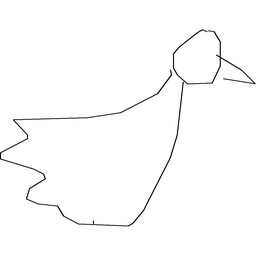

bird
bird == bird ? True


In [30]:
sample = test.sample(1)
sample_predict = sample.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word'])

if pca_on:
    sample_predict = scaler.transform(sample_predict)
    sample_predict = pca.transform(sample_predict)

prediction = model.predict(sample_predict)
display(IPImage(render_single(sample['drawing'].iloc[0])))
print(prediction[0])
print(f"{sample['word'].iloc[0]} == {prediction[0]} ? {sample['word'].iloc[0] == prediction[0]}")

In [26]:
test2 = test.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word'])
if pca_on:
    test2 = scaler.transform(test2)
    test2 = pca.transform(test2)
prediction = model.predict(test2)

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(test['word'].values.tolist(), prediction)
print(f"Accuracy score: {acc_score}")

Accuracy score: 0.955
